# Computer Vision Project: Roundabout

Submited By: **Aaron Leviashvili**  and **Shay Mualem** 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
print(cv2.__version__)

plt.rc('image', cmap='gray') # set the default color-map of plt.image() to 'gray'
plt.rc('figure', figsize=[15,15]) # set a bigger default figure size

4.5.0


# Part 1: Video Stabilization

Main Algorithm: Calculating Optical flow between two frames and stabilizing the image against the rotation of the image.

Pipeline is outlined in the following cells.

In [2]:
# Initializing capture of the video
cap = cv2.VideoCapture('P1_roundabout.mp4')

# Parameters for the stabilized output video
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Zero Padding parameter
N = 300
W = W + 2*N
H = H + 2*N

# Initializing video writing 
out = cv2.VideoWriter('P1_roundabout_stabilized.mp4',fourcc, FPS, (W,H))

In [3]:
# Parameters for corner detection
feature_params = dict( maxCorners = 3000,
                       qualityLevel = 0.01,
                       minDistance = 10,
                       blockSize = 5 )

# Parameters for optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

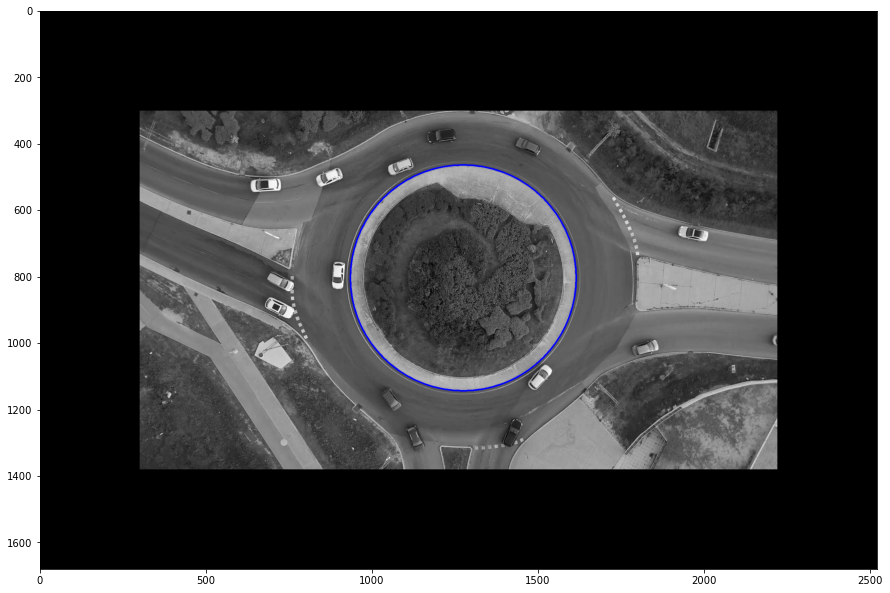

In [4]:
ret, firstFrame = cap.read()
# For demonstration puprposes we skip a few frames
for _ in range(8):
    ret, secondFrame = cap.read()
firstFrame = cv2.copyMakeBorder(firstFrame, N, N, N, N, cv2.BORDER_CONSTANT)
secondFrame = cv2.copyMakeBorder(secondFrame, N, N, N, N, cv2.BORDER_CONSTANT)
firstFrame_gray = cv2.cvtColor(firstFrame, cv2.COLOR_BGR2GRAY)
secondFrame_gray = cv2.cvtColor(secondFrame, cv2.COLOR_BGR2GRAY)

# Smoothing out the image for canny edge detector
firstFrame_blur = cv2.GaussianBlur(firstFrame_gray,(0,0),2)

# Detecting the circles in the image
firstFrame_circles = cv2.HoughCircles(firstFrame_blur,method=cv2.HOUGH_GRADIENT,dp=1,minDist=40,
                           param1=100,param2=20,minRadius=340,maxRadius=345)

# Converting the resulting image from float32 type to int
firstFrame_circles = firstFrame_circles.astype(np.int)

# Converting the image that was loaded in grayscale back to it's original RGB form
firstFrame_rgb = cv2.cvtColor(firstFrame_gray, cv2.COLOR_GRAY2RGB)

# Drawing the detected circles over the image
for (x,y,r) in firstFrame_circles[0]:
    cv2.circle(firstFrame_rgb,(x,y),r,(0,0,255),3)

plt.imshow(firstFrame_rgb)

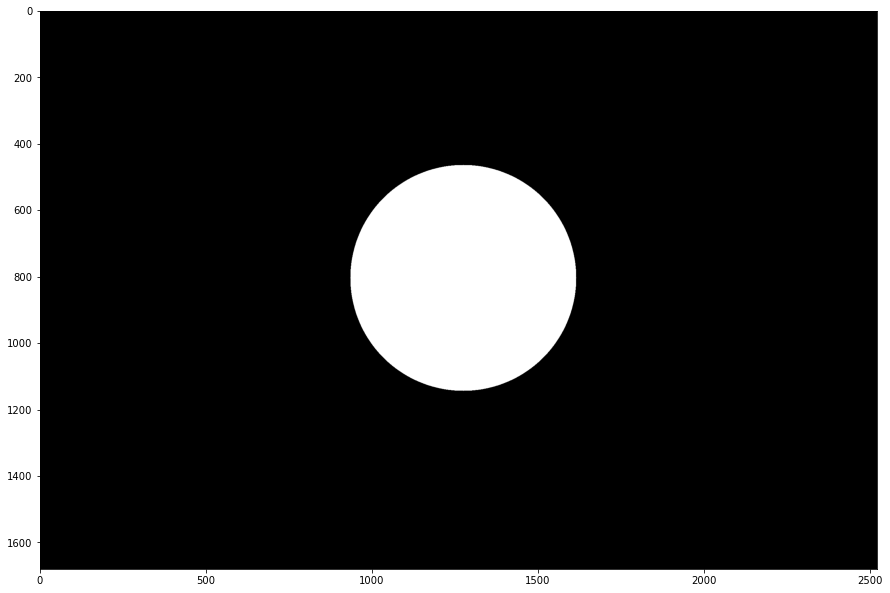

In [5]:
# Creating the Image mask
centerMask = np.zeros(firstFrame.shape, dtype=np.uint8)

for (x,y,r) in firstFrame_circles[0]:
    cv2.circle(centerMask,(x,y),r,(255,255,255),-1)
    
centerMask = cv2.cvtColor(centerMask, cv2.COLOR_BGR2GRAY)

plt.imshow(centerMask)

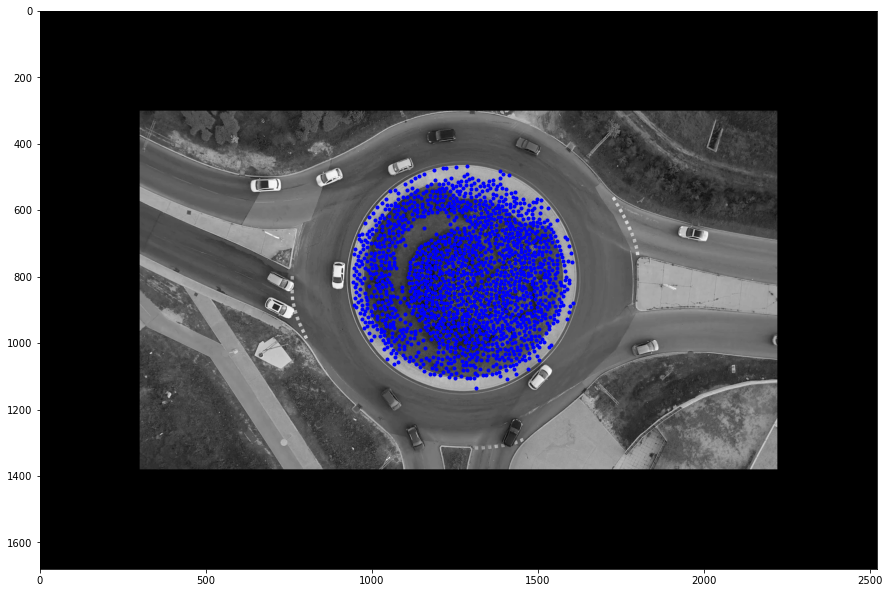

In [6]:
# First We detect good features to track in the first frame
firstFramePoints = cv2.goodFeaturesToTrack(firstFrame_gray, mask = centerMask, **feature_params)

plt.imshow(firstFrame_gray)
plt.plot(firstFramePoints[:,0,0], firstFramePoints[:,0,1],'.b')

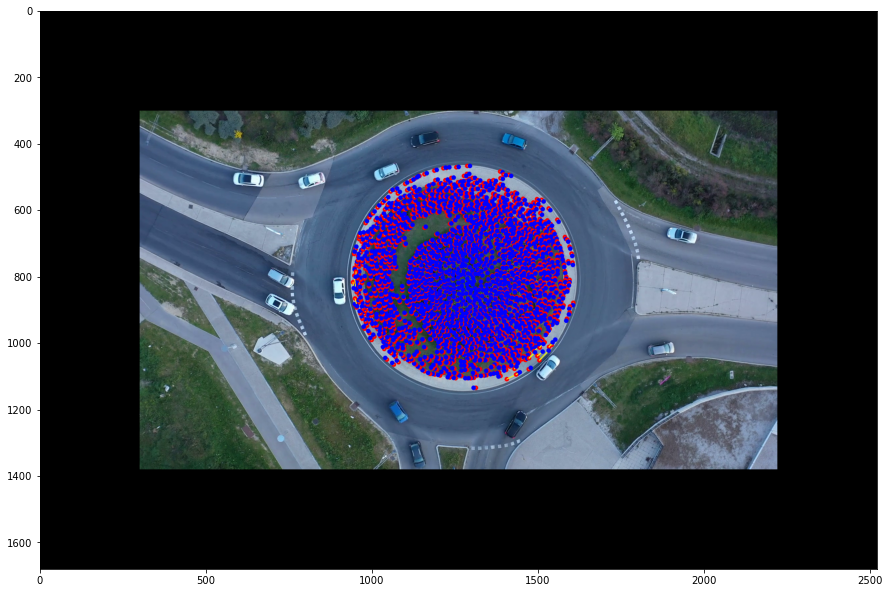

In [7]:
# Now we calculate optical flow of the points from the first frame to the second
secondFramePoints, status, err = cv2.calcOpticalFlowPyrLK(firstFrame_gray, secondFrame_gray, 
                                                          firstFramePoints, None, **lk_params)

canvas = secondFrame.copy()

# Let's draw the matches between the points
for (p0,p1) in zip(firstFramePoints,secondFramePoints):
            x0,y0 = p0.squeeze().astype(np.int)
            x1,y1 = p1.squeeze().astype(np.int)
            canvas = cv2.circle(canvas,(x0,y0),7,(0,0,255),-1)
            canvas = cv2.line(canvas, (x0,y0),(x1,y1), (0,255,255), 2) 
            canvas = cv2.circle(canvas,(x1,y1),7,(255,0,0),-1)
            
plt.imshow(cv2.cvtColor(canvas,cv2.COLOR_BGR2RGB))

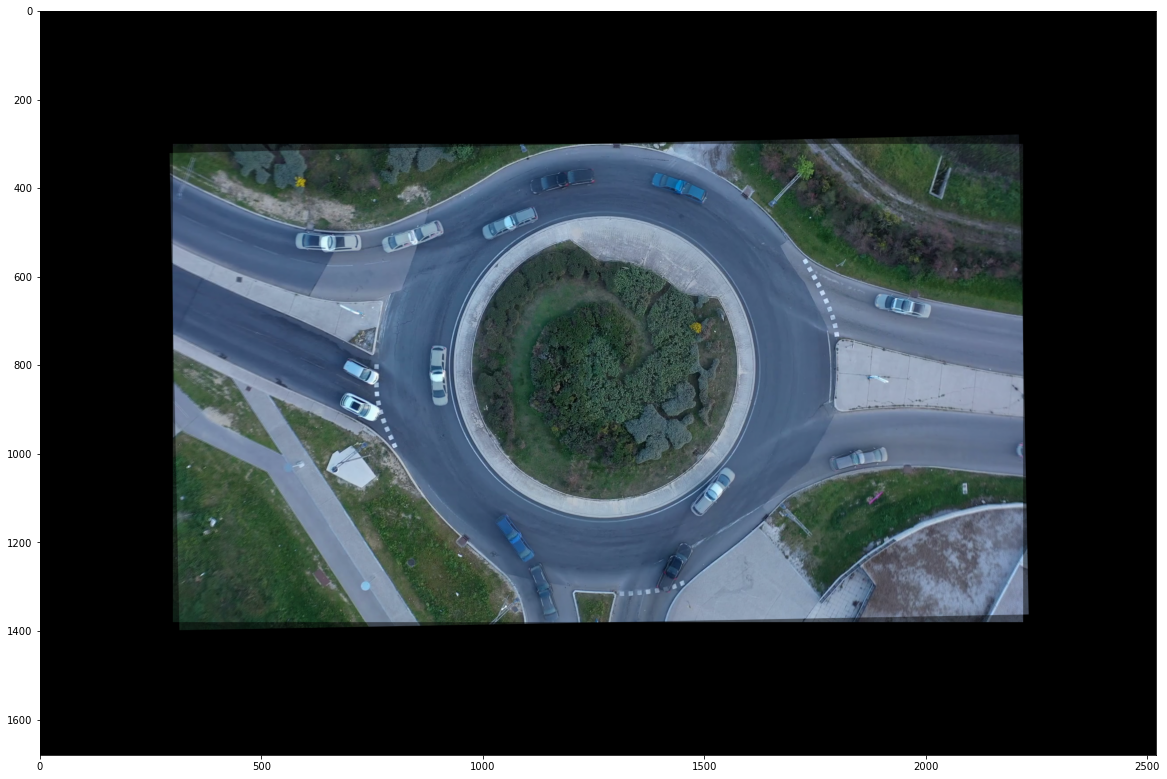

In [8]:
# After we have the both sets of points we can calculate the transformation
M, mask = cv2.findHomography(secondFramePoints, firstFramePoints, cv2.RANSAC,30.0)

# Applying the transformation to match the second frame to the first
h,w = firstFrame_gray.shape
secondFrame_warp = cv2.warpPerspective(secondFrame, M, (w,h))

# Splicing the two images together
splice = cv2.addWeighted(secondFrame_warp,0.5,firstFrame,0.5,0)
plt.figure(figsize=(20,20))

# We can observe in this image that scenery is matched correctly and the trajectory of the cars is smooth
plt.imshow(cv2.cvtColor(splice,cv2.COLOR_BGR2RGB), cmap='gray')

In [9]:
cap = cv2.VideoCapture('P1_roundabout.mp4')

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Zero Padding parameter
N = 300
W = W + 2*N
H = H + 2*N

# Initializing video writing 
out = cv2.VideoWriter('P1_roundabout_stabilized.mp4',fourcc, FPS, (W,H))

# Parameters for detecting initial tracking features (corners)
feature_params = dict( maxCorners = 3000,
                       qualityLevel = 0.01,
                       minDistance = 10,
                       blockSize = 5 )

# Parameters for Optical Flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Taking the first frame and finding good points to track in it
ret, F0 = cap.read()
F0 = cv2.copyMakeBorder(F0, N, N, N, N, cv2.BORDER_CONSTANT)
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = centerMask, **feature_params)
out.write(F0)

ret,F1 = cap.read()
F1 = cv2.copyMakeBorder(F1, N, N, N, N, cv2.BORDER_CONSTANT)
F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)
pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params)
M, mask = cv2.findHomography(pts1, pts0, cv2.RANSAC,30.0)
h,w = F0_gray.shape
F1_warp = cv2.warpPerspective(F1, M, (w,h))
out.write(F1_warp)

if ret:
    while True:
        ret,F2 = cap.read()
        F2 = cv2.copyMakeBorder(F2, N, N, N, N, cv2.BORDER_CONSTANT)

        if ret==True:
            F2_gray = cv2.cvtColor(F2, cv2.COLOR_BGR2GRAY)

            # Calculating Optical Flow
            pts2, status, err = cv2.calcOpticalFlowPyrLK(F1_gray, F2_gray, pts1, None, **lk_params)

            M, mask = cv2.findHomography(pts2, pts0, cv2.RANSAC,30.0)

            h,w = F0_gray.shape
            F2_warp = cv2.warpPerspective(F2, M, (w,h))

        if ret==True:
            cv2.imshow('WINDOW_NAME', F2_warp)
            out.write(F2_warp)
            if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
                break
            F1 = F2
            F1_gray = F2_gray
            pts1 = pts2
        else:
            break

cap.release() # release input video
out.release() # release output video 
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);

# Part 2: Vehicle Tracking

First the vehicles are isolated from the background using absolute frame difference (After Stabilization the vehicles are the only moving thing in the video.)

Then the black and white Images are used as mask for Shi-Tomasi GoodFeaturesToTrack and keypoints are detected only on the vehicles themselves.

Pipeline is outlined in the following cells.

In [10]:
# Setting up the parameters for the two algorithms
# Parametrs for detecting initial tracking features (corners)
feature_params = dict( maxCorners = 10,
                       qualityLevel = 0.09,
                       minDistance = 10,
                       blockSize = 5 )

# Parameters for Optical Flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [11]:
# Initializing the capture
cap = cv2.VideoCapture('P1_roundabout_stabilized.mp4')

# Initializing VIdeo Writing
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Initializing video writing 
out = cv2.VideoWriter('P1_roundabout_stabilized_With_Vehicle_Tracking.mp4',fourcc, FPS, (W,H))

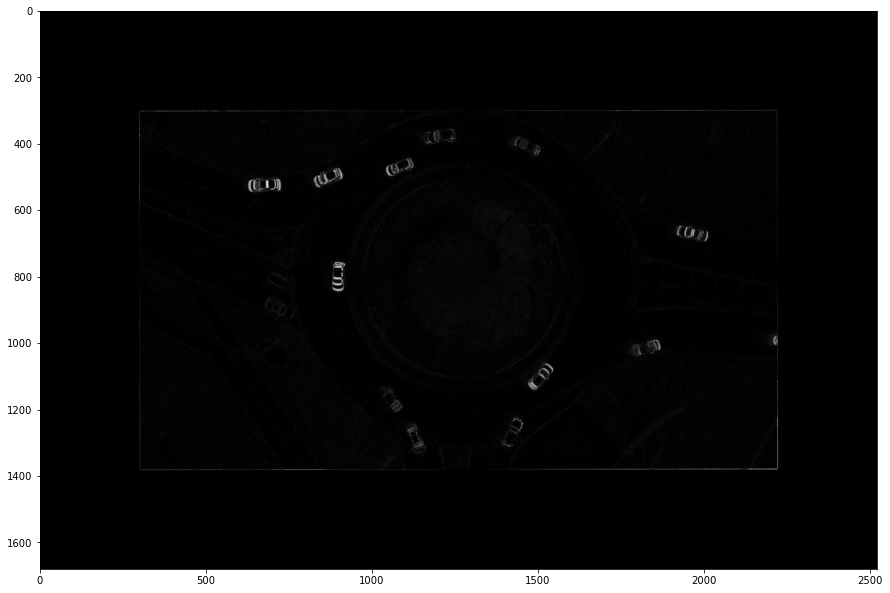

In [12]:
# Taking the first two frames from the video
ret, F0 = cap.read()
ret, F1 = cap.read()
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)

# Calculating absolute difference between the two frames
FirstFrameDiff = cv2.absdiff(F0_gray,F1_gray)
plt.imshow(FirstFrameDiff)

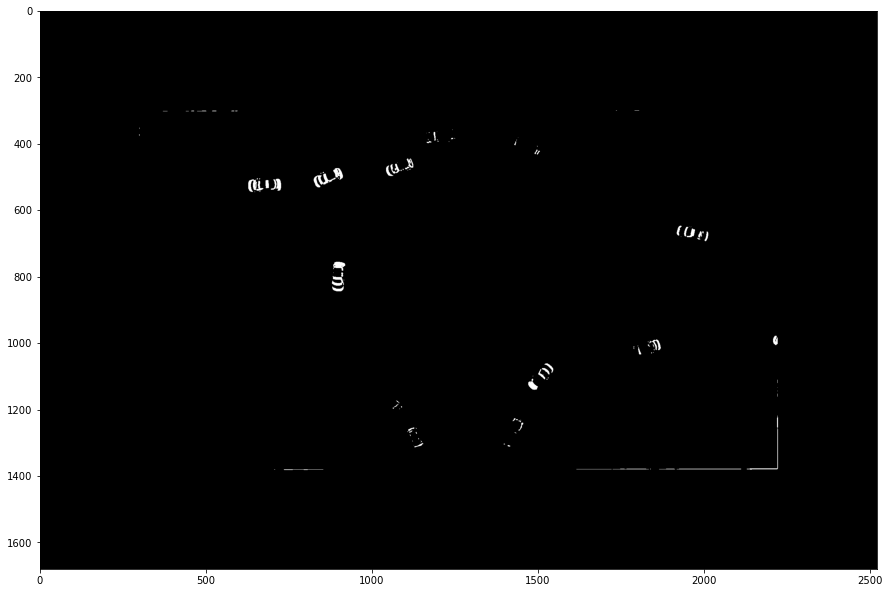

In [13]:
# Blurring the Image and thresholding to get the outlines of the moving cars
FirstBlur = cv2.GaussianBlur(FirstFrameDiff, (5,5), 0)
_, FirstThresh = cv2.threshold(FirstBlur, 50, 255, cv2.THRESH_BINARY)

plt.imshow(FirstThresh)

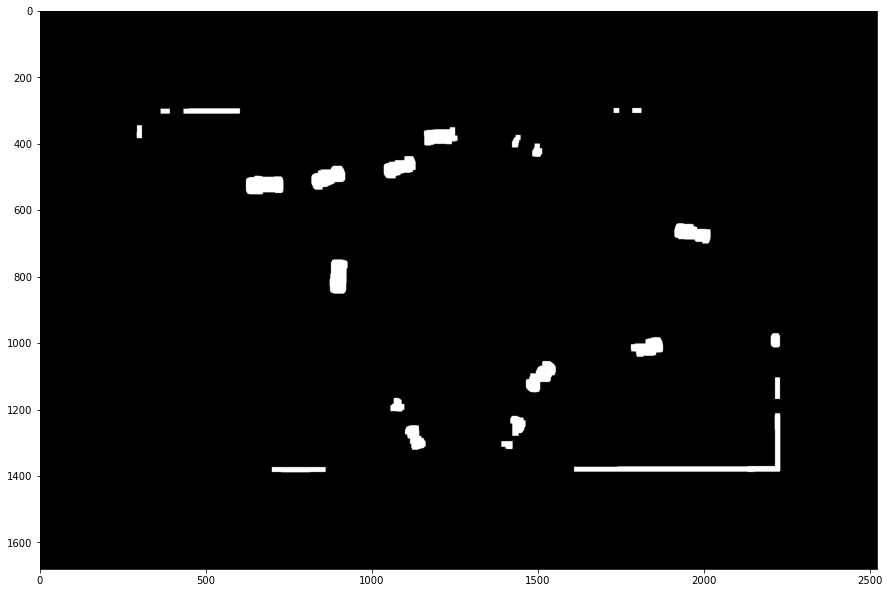

In [14]:
# Applying morphology to enhance the contours of the cars, the goal is to cover the car as much as possible
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(FirstThresh, kernel, iterations=2)
closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel, iterations = 10)
contour_mask = cv2.dilate(closing, None, iterations=3)

plt.imshow(contour_mask)

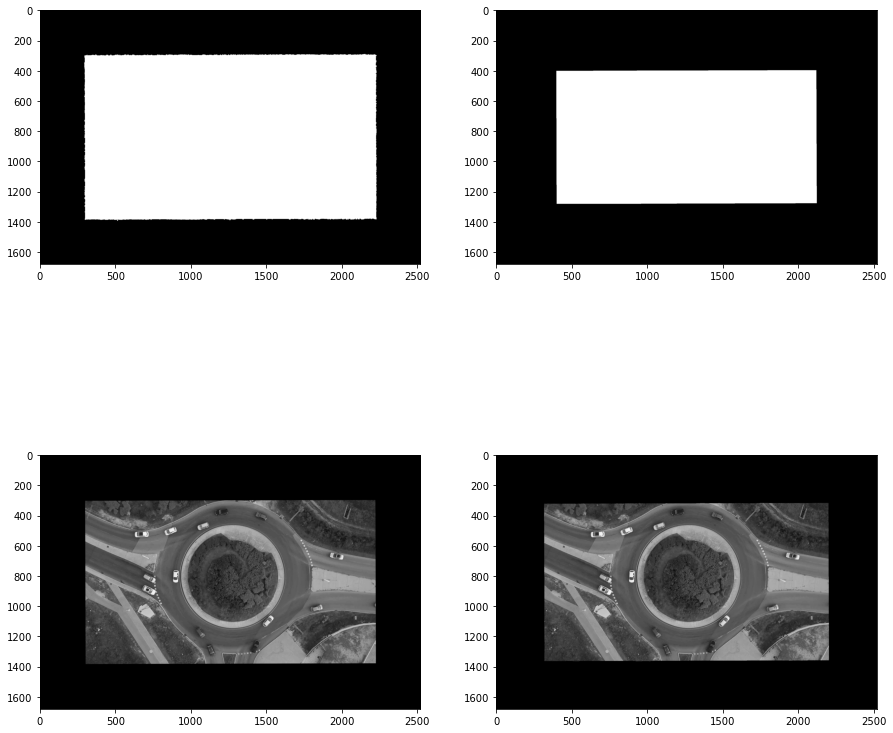

In [15]:
# In order to drown out the white frame outlines caused by frame rotation a mask is created

# Thresholded frame outline (A white square)
_, FrameOutlines = cv2.threshold(F1_gray, 1, 255, cv2.THRESH_BINARY)

# The white square is minimized to fit the frame and exclude the white rotation lines
kernel = np.ones((5, 5), np.uint8)
FrameOutlines = cv2.dilate(FrameOutlines, kernel)
FrameOutlines_eroded = cv2.erode(FrameOutlines,kernel)
FrameOutlines_eroded_demo = cv2.erode(FrameOutlines,kernel)
for _ in range(50): # Here erosion is exaggerated for demonstration purposes
    FrameOutlines_eroded_demo = cv2.erode(FrameOutlines_eroded_demo,kernel)
for _ in range(10): # This is enough to drown out the noise
    FrameOutlines_eroded = cv2.erode(FrameOutlines_eroded,kernel)

outlinesCleared = cv2.bitwise_and(FrameOutlines_eroded, F1_gray)

plt.subplot(2,2,1)
plt.imshow(FrameOutlines)
plt.subplot(2,2,2)
plt.imshow(FrameOutlines_eroded_demo)
plt.subplot(2,2,3)
plt.imshow(F1_gray)
plt.subplot(2,2,4)
plt.imshow(outlinesCleared)

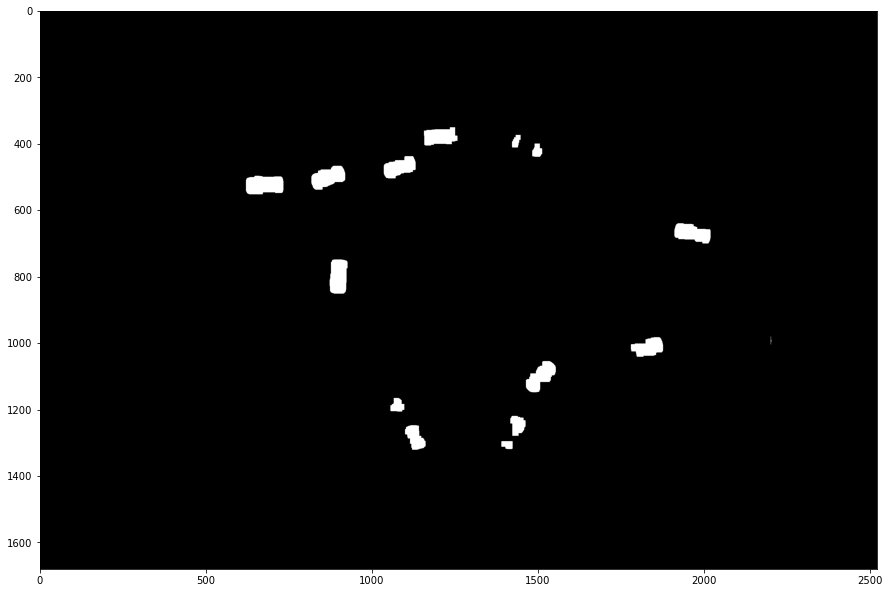

In [16]:
# Applied on the contour_mask
contour_mask = cv2.bitwise_and(contour_mask, FrameOutlines_eroded)

plt.imshow(contour_mask)

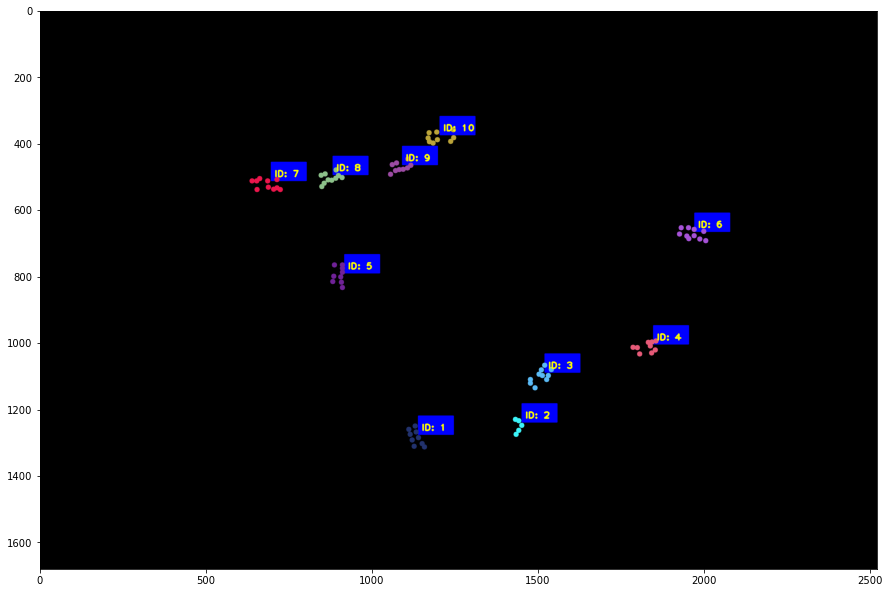

In [17]:
# Finding contours in the first image
Contours, _ = cv2.findContours(contour_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
idLabelMask = cv2.cvtColor(contour_mask,cv2.COLOR_GRAY2BGR)

# Information about the Cars
cars = [] # Contains list of keypoints (Features of a car), color and ID number
idCounter = 0 # How many unique ID's so far have been given

# Everything we need for vizualizing the tracking
canvas = np.zeros_like(F0)
idBoxOffset = 10
idBoxSize = 65

# Treating each contour as a car, filtering the keypoints and giving it ID
for ctrIdx in range(len(Contours)):
    if cv2.contourArea(Contours[ctrIdx]) > 1400:
        idCounter += 1
        ID = idCounter # Assigning unique ID to the car
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Generating Random tracking color
        
        # Detecting features of the car
        oneCarMask = np.zeros_like(contour_mask)
        oneCarMask = cv2.drawContours(oneCarMask, Contours, ctrIdx, (255, 255, 255), -1)
        carFeatures = cv2.goodFeaturesToTrack(F0_gray, mask = oneCarMask, **feature_params)
        
        # Appending the data to the cars list
        cars.append([ID,color,carFeatures])
        
        # Calculating the median point to draw the ID square (median is better, average might drift)
        med = np.median(carFeatures, axis=(0,1))
        cx = int(med[0])
        cy = int(med[1])
        
        # Drawing the ID square and the points on the ID label canvas
        pts = np.int32([ [cx + idBoxOffset,cy - idBoxSize],[cx + idBoxSize + 50,cy - idBoxSize],
                        [cx + idBoxSize + 50,cy - idBoxOffset],[cx + idBoxOffset,cy - idBoxOffset] ]).reshape(-1,1,2)
        idLabelCanvas = cv2.polylines(canvas,[pts],True,(255,0,0),2, cv2.LINE_AA)
        idLabelCanvas = cv2.fillPoly(canvas,[pts],(255,0,0))
        for p0 in carFeatures:
            x0,y0 = p0.squeeze().astype(np.int)
            canvas = cv2.circle(canvas,(x0,y0),8,color,-1) # new points
        canvas = cv2.putText(canvas,'ID: ' + str(ID), org = (cx + 20, cy - 20),
                    fontFace = cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color = (0,255,255), thickness = 3,lineType = 1)

plt.imshow(cv2.cvtColor(canvas,cv2.COLOR_BGR2RGB))

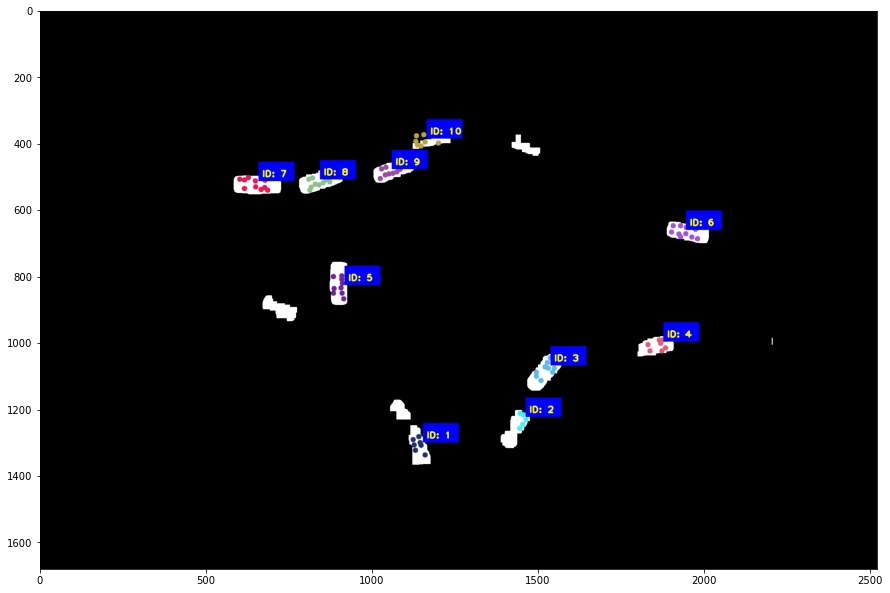

In [18]:
F0_gray = F1_gray

# Fast Forward a few frames and now try to find the same cars
for _ in range(5):
    ret,F1 = cap.read()
F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)

# Frame Difference and morphology
FrameDiff = cv2.absdiff(F0_gray,F1_gray)
Blur = cv2.GaussianBlur(FrameDiff, (5,5), 0)
_, Thresh = cv2.threshold(Blur, 50, 255, cv2.THRESH_BINARY)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(Thresh, kernel, iterations=2)
closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel, iterations = 10)
contour_mask = cv2.dilate(closing, None, iterations=3)

# This mask allows us to drown out the frame rotation noise so we can focus only on the cars themselves.
_, carMask = cv2.threshold(F1_gray, 1, 255, cv2.THRESH_BINARY)
kernel = np.ones((5, 5), np.uint8)
carMask = cv2.dilate(carMask, kernel)
for i in range(10):
    carMask = cv2.erode(carMask,kernel)
    
contour_mask = cv2.bitwise_and(contour_mask, carMask)

# Converting contour mask to color for demo purposes (Not part of the algorithm)
contour_mask = cv2.cvtColor(contour_mask,cv2.COLOR_GRAY2BGR)

for i in range(len(cars)):
        oldPoints = cars[i][2]
        trackingColor = cars[i][1]
        ID = cars[i][0]
        newPoints, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, oldPoints, None, **lk_params)
    
        # Calculating the median point to draw the ID square (median is better, average might drift)
        med = np.median(newPoints, axis=(0,1))
        cx = int(med[0])
        cy = int(med[1])
        
        # Deleting the points that are outside the frame outlines or that get stuck somewhere
        for p1,stat in zip(newPoints,status):
            x1,y1 = p1.squeeze().astype(np.int)
            if(np.absolute(x1 - cx) > 50 or np.absolute(y1 - cy) > 50):
                stat[0] = 0
            else:
                x1,y1 = p1.squeeze().astype(np.int)
                contour_mask = cv2.circle(contour_mask,(x1,y1),8,trackingColor,-1) # new points
        
        # Removing irrelevant points
        newPoints = newPoints[status[:,0]==1]
        
        # Drawing the ID square on the ID label canvas
        pts = np.int32([ [cx + idBoxOffset,cy - idBoxSize],[cx + idBoxSize + 50,cy - idBoxSize],
                        [cx + idBoxSize + 50,cy - idBoxOffset],
                        [cx + idBoxOffset,cy - idBoxOffset] ]).reshape(-1,1,2)
        contour_mask = cv2.polylines(contour_mask,[pts],True,(255,0,0),2, cv2.LINE_AA)
        contour_mask = cv2.fillPoly(contour_mask,[pts],(255,0,0))
        contour_mask= cv2.putText(contour_mask,'ID: ' + str(ID), org = (cx + 20, cy - 20),
                    fontFace = cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color = (0,255,255), thickness = 3,lineType = 1)
        

plt.imshow(cv2.cvtColor(contour_mask,cv2.COLOR_BGR2RGB))

# The final tracking algorithm running on video:

First cell is the setup using the first two frames, second cell analyzes the rest of the video.

In [19]:
# Setting up the parameters for the two algorithms
# Params for corner detection
feature_params = dict( maxCorners = 10,
                       qualityLevel = 0.09,
                       minDistance = 10,
                       blockSize = 5 )

# Parameters for optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Initializing the capture
cap = cv2.VideoCapture('P1_roundabout_stabilized.mp4')

# Initializing VIdeo Writing
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('P1_roundabout_stabilized_With_Vehicle_Tracking.mp4',fourcc, FPS, (W,H))

# Capturing the first two frames and converting their color to gray
ret, F0 = cap.read()
ret, F1 = cap.read()
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)


# This mask allows us to drown out the frame rotation noise so we can focus only on the cars themselves.
_, carMask = cv2.threshold(F1_gray, 1, 255, cv2.THRESH_BINARY) # We get a white rectangle in the middle.
kernel = np.ones((5, 5), np.uint8)
carMask = cv2.dilate(carMask, kernel) # Dilation will remove any small imperfections in the rectangle so they don't compound.
for _ in range(10):
    carMask = cv2.erode(carMask,kernel) # Erosion of the mask with a few passes allows us to make the rectangle smaller

# Calculating absolute difference between the frames to locate moving objects
FirstFrameDiff = cv2.absdiff(F0_gray,F1_gray)

# Preparing the frame difference image to be processed
FirstBlur = cv2.GaussianBlur(FirstFrameDiff, (5,5), 0)
_, FirstThresh = cv2.threshold(FirstBlur, 50, 255, cv2.THRESH_BINARY)

# Applying morphology to bring out the contours of moving objects even more
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
dilate = cv2.dilate(FirstThresh, kernel, iterations=2)
closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel, iterations = 10)
contour_mask = cv2.dilate(closing, kernel, iterations=3)

# Drowning out frame rotation noise
contour_mask = cv2.bitwise_and(contour_mask, carMask)

# Once the contour_mask contains only moving cars we can proceed to detect them
Contours, _ = cv2.findContours(contour_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Information about the Cars
cars = [] # will be a list of car objects, each car will have keypoints (Features of a car), color and ID number
idCounter = 0 # Keeping track of unique ID's given

# Everything we need for vizualizing 
trackingPointCanvas = np.zeros_like(F0)
idLabelCanvas = np.zeros_like(F0)
idBoxOffset = 10
idBoxSize = 65

# Treating each contour as a car
for ctrIdx in range(len(Contours)):
    if cv2.contourArea(Contours[ctrIdx]) > 1400:
        idCounter += 1
        ID = idCounter # Assigning unique ID to the car
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Generating Random tracking color
        
        # Detecting features of the car
        oneCarMask = np.zeros_like(contour_mask)
        oneCarMask = cv2.drawContours(oneCarMask, Contours, ctrIdx, (255, 255, 255), -1)
        carFeatures = cv2.goodFeaturesToTrack(F0_gray, mask = oneCarMask, **feature_params)
        
        # Appending the data to the cars list
        cars.append([ID,color,carFeatures])
        
        # Calculating the median point to draw the ID square (median is better, average might drift)
        med = np.median(newPoints, axis=(0,1))
        cx = int(med[0])
        cy = int(med[1])
        
        # Drawing the ID square on the ID label canvas
        pts = np.int32([ [cx + idBoxOffset,cy - idBoxSize],[cx + idBoxSize + 50,cy - idBoxSize],
                        [cx + idBoxSize + 50,cy - idBoxOffset],[cx + idBoxOffset,cy - idBoxOffset] ]).reshape(-1,1,2)
        idLabelCanvas = cv2.polylines(idLabelCanvas,[pts],True,(255,0,0),2, cv2.LINE_AA)
        idLabelCanvas = cv2.fillPoly(idLabelCanvas,[pts],(255,0,0))
        canvas2idLabelCanvas= cv2.putText(idLabelCanvas,'ID: ' + str(ID), org = (cx + 20, cy - 20),
                    fontFace = cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color = (0,255,255), thickness = 3,lineType = 1)

In [20]:
F0_gray = F1_gray

while(1):
    ret,F1 = cap.read()
    
    if ret==True:
        F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)
        idLabelCanvas = np.zeros_like(F1)
    
        # This mask allows us to drown out the frame rotation noise so we can focus only on the cars themselves.
        _, carMask = cv2.threshold(F1_gray, 1, 255, cv2.THRESH_BINARY)
        kernel = np.ones((5, 5), np.uint8)
        carMask = cv2.dilate(carMask, kernel)
        pointFade = carMask.copy()
        for i in range(10):
            carMask = cv2.erode(carMask,kernel)
            if i%2 == 0:
                pointFade = cv2.erode(pointFade,kernel)

        # Calculating using frame difference the new contours of the cars
        FrameDiff = cv2.absdiff(F0_gray,F1_gray)
        Blur = cv2.GaussianBlur(FrameDiff, (5,5), 0)
        _, Thresh = cv2.threshold(Blur, 50, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        dilate = cv2.dilate(Thresh, kernel, iterations=1)
        closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel, iterations = 10)
        contour_mask = cv2.dilate(closing, kernel, iterations=3)
        contour_mask = cv2.bitwise_and(contour_mask, carMask)        
        
        i = 0
        # Tracking each car
        while i < len(cars):
            oldPoints = cars[i][2]
            trackingColor = cars[i][1]
            ID = cars[i][0]
            newPoints, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, oldPoints, None, **lk_params)
            
            # Calculating the median point to draw the ID square (median is better, average might drift)
            med = np.median(newPoints, axis=(0,1))
            cx = int(med[0])
            cy = int(med[1])

            for p1,stat in zip(newPoints,status):
                x1,y1 = p1.squeeze().astype(np.int)
                
                # Deleting the points that are outside the frame outlines or that get stuck somewhere
                if(np.absolute(x1 - cx) > 50 or np.absolute(y1 - cy) > 50 or x1 > W or y1 > H or
                   pointFade[y1][x1] == 0):
                    stat[0] = 0
                else:
                    contour_mask = cv2.circle(contour_mask, (x1,y1),120,0,-1) # Erasing the car from detection
            
            # Updating the points that are still left
            newPoints = newPoints[status[:,0]==1]
            if len(newPoints) < 2:
                cars.remove(cars[i])
            else:
                cars[i][2] = newPoints
                i += 1

                # Drawing a tracking circle for the car
                trackingPointCanvas = cv2.circle(trackingPointCanvas,(cx,cy),18,trackingColor,-1)
                # Drawing the ID square on the ID label canvas
                pts = np.int32([ [cx + idBoxOffset,cy - idBoxSize],[cx + idBoxSize + 50,cy - idBoxSize],
                                [cx + idBoxSize + 50,cy - idBoxOffset],
                                [cx + idBoxOffset,cy - idBoxOffset] ]).reshape(-1,1,2)
                idLabelCanvas = cv2.polylines(idLabelCanvas,[pts],True,(255,0,0),2, cv2.LINE_AA)
                idLabelCanvas = cv2.fillPoly(idLabelCanvas,[pts],(255,0,0))
                canvas2idLabelCanvas= cv2.putText(idLabelCanvas,'ID: ' + str(ID), org = (cx + 20, cy - 20),
                            fontFace = cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color = (0,255,255), thickness = 3,lineType = 1)
        
        
        Contours, _ = cv2.findContours(contour_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for ctrIdx in range(len(Contours)):
            if cv2.contourArea(Contours[ctrIdx]) > 1400:
                idCounter += 1
                ID = idCounter
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                oneCarMask = np.zeros_like(contour_mask)
                oneCarMask = cv2.drawContours(oneCarMask, Contours, ctrIdx, (255, 255, 255), -1)
                carFeatures = cv2.goodFeaturesToTrack(F0_gray, mask = oneCarMask, **feature_params)

                cars.append([ID,color,carFeatures])
                    
        # visualize the results
        trackingPointCanvas = np.uint8(trackingPointCanvas*0.99) # Fading out older points
        trackingPointCanvas = cv2.GaussianBlur(trackingPointCanvas, (5,5), 0) # Blurring trails
        final = cv2.addWeighted(F1, 1, trackingPointCanvas, 0.5, 0) # Blending the Images
        final = cv2.add(final, idLabelCanvas)
        cv2.putText(final,'Tracking ' + str(len(cars)) + ' Vehicles', org = (80,80),
                   fontFace = cv2.FONT_HERSHEY_PLAIN,
                   fontScale = 3,
                   color = (0,255,255),
                   thickness = 3,
                   lineType = 1) 
        cv2.imshow('ctr',contour_mask)
        cv2.imshow('final',final)
        out.write(final)
            
        # Updating the previous frame
        F0_gray = F1_gray

        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break

    else: # No more frames to read
        break

cv2.destroyAllWindows()
cap.release()
out.release()
cv2.waitKey(1)

-1